

```
# DATA LOAD

# build model 1:

#model 2 for comparison if we find another

#need to figure out how to incorporate location of injury


```



In [ ]:
!pip install keras

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.layers import Activation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import cv2
import pickle
import tifffile as tiff
import matplotlib.pyplot as plt
import json
import os

from pathlib import Path
from glob import glob
from PIL import Image, ImageDraw
from tqdm import tqdm


In [2]:
#data load
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"m4teo020","key":"a1e2ff66ad7e7d42b5a3c807b7ff069e"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d sohaibanwaar1203/kneemridataset -p ./data --unzip


Dataset URL: https://www.kaggle.com/datasets/sohaibanwaar1203/kneemridataset
License(s): unknown
100% 3.08G/3.08G [00:32<00:00, 41.5MB/s]
100% 3.08G/3.08G [00:32<00:00, 101MB/s] 


In [6]:


for root, dirs, files in os.walk('./data'):
    for file in files:
        print(os.path.join(root, file))


./data/metadata.csv
./data/vol05/739469-5.pck
./data/vol05/704348-5.pck
./data/vol05/725464-5.pck
./data/vol05/742110-5.pck
./data/vol05/703073-5.pck
./data/vol05/685842-5.pck
./data/vol05/700481-5.pck
./data/vol05/689147-5.pck
./data/vol05/700785-5.pck
./data/vol05/749611-5.pck
./data/vol05/737151-5.pck
./data/vol05/742140-5.pck
./data/vol05/749859-5.pck
./data/vol05/714569-5.pck
./data/vol05/730439-5.pck
./data/vol05/676612-5.pck
./data/vol05/683478-5.pck
./data/vol05/718175-5.pck
./data/vol05/688886-5.pck
./data/vol05/737279-5.pck
./data/vol05/742136-5.pck
./data/vol05/749920-5.pck
./data/vol05/705666-5.pck
./data/vol05/683028-8.pck
./data/vol05/682602-5.pck
./data/vol05/745206-5.pck
./data/vol05/731748-5.pck
./data/vol05/727832-5.pck
./data/vol05/688833-6.pck
./data/vol05/723427-5.pck
./data/vol05/742863-5.pck
./data/vol05/716903-5.pck
./data/vol05/749555-5.pck
./data/vol05/740062-5.pck
./data/vol05/717994-5.pck
./data/vol05/751087-5.pck
./data/vol05/733146-5.pck
./data/vol05/73974

In [7]:



pck_files = []

# Collect all .pck files
for root, dirs, files in os.walk('./data'):
    for file in files:
        if file.endswith('.pck'):
            pck_files.append(os.path.join(root, file))

print(f"Found {len(pck_files)} .pck files.")

# Load and inspect the first few files
for i, path in enumerate(pck_files[:5]):
    with open(path, 'rb') as f:
        data = pickle.load(f)

    print(f"\nFile: {path}")
    print(f"Type: {type(data)}")

    if isinstance(data, dict):
        print(f"Keys: {data.keys()}")
    elif hasattr(data, 'shape'):
        print(f"Shape: {data.shape}")
    else:
        print(f"Sample content: {str(data)[:500]}")  # Preview if it's something else



Found 736 .pck files.

File: ./data/vol05/739469-5.pck
Type: <class 'numpy.ndarray'>
Shape: (30, 320, 320)

File: ./data/vol05/704348-5.pck
Type: <class 'numpy.ndarray'>
Shape: (30, 320, 320)

File: ./data/vol05/725464-5.pck
Type: <class 'numpy.ndarray'>
Shape: (30, 320, 320)

File: ./data/vol05/742110-5.pck
Type: <class 'numpy.ndarray'>
Shape: (30, 320, 320)

File: ./data/vol05/703073-5.pck
Type: <class 'numpy.ndarray'>
Shape: (30, 320, 320)


In [8]:


meta = pd.read_csv('./data/metadata.csv')  # or wherever it's stored
print(meta.head())


   examId  seriesNo  aclDiagnosis  kneeLR  roiX  roiY  roiZ  roiHeight  \
0  329637         8             0       1   139   184    14         74   
1  390116         9             0       0   113   105    10         83   
2  404663         8             1       1   120   117    15        101   
3  406320         9             0       0   117   124    12         91   
4  412857         8             0       1   122   105    14         83   

   roiWidth  roiDepth volumeFilename  
0        72         3   329637-8.pck  
1        98         6   390116-9.pck  
2       115         2   404663-8.pck  
3        80         3   406320-9.pck  
4        98         4   412857-8.pck  


In [9]:
labels = dict(zip(meta['volumeFilename'], meta['aclDiagnosis']))


In [10]:


ROOT_DIR    = Path("./data")
OUTPUT_DIR  = Path("jpeg_out")
OUTPUT_DIR.mkdir(exist_ok=True)

keep = set()

def to_uint8(arr):
    """Make sure each slice is uint8 in [0,255] for Pillow."""
    if arr.dtype != np.uint8:
        arr = arr.astype(np.float32)
        arr -= arr.min()
        maxv = arr.max()
        if maxv:                   # avoid divide-by-zero
            arr /= maxv
        arr = (arr * 255).clip(0, 255).astype(np.uint8)
    return arr

def save_slice(arr2d: np.ndarray, out_path: Path):
    img = Image.fromarray(to_uint8(arr2d), mode="L")   # grayscale
    img.save(out_path, format="JPEG", quality=95)

for root, _, files in os.walk(ROOT_DIR):
    for fname in files:
        if not fname.endswith(".pck"):
            continue
        stem = Path(fname).stem         # filename without .pck
        if keep and stem not in keep:
            continue                    # skip if not in label list

        pkl_path = Path(root) / fname
        with open(pkl_path, "rb") as f:
            volume = pickle.load(f)     # (S, H, W) or (H, W)

        # 2-D pickle → single JPEG
        if volume.ndim == 2:
            out_name = f"{stem}.jpg"
            save_slice(volume, OUTPUT_DIR / out_name)

        # 3-D pickle → one JPEG per slice
        elif volume.ndim == 3:
            for idx in range(volume.shape[0]):
                out_name = f"{stem}_slice{idx:03d}.jpg"
                save_slice(volume[idx], OUTPUT_DIR / out_name)

        else:
            print(f"⚠️  {pkl_path} skipped — unsupported shape {volume.shape}")

print(f"Done — JPEGs stored in {OUTPUT_DIR.resolve()}")


Done — JPEGs stored in /content/jpeg_out


In [11]:


CSV_PATH     = './data/metadata.csv'
JPEG_DIR     = Path("jpeg_out")        # where your *_slice###.jpg live
MASK_DIR     = Path("mask_out")        # will hold *_slice###_mask.png
MASK_DIR.mkdir(exist_ok=True)
VIA_JSON     = "via_annotations.json"  # final VIA file

df = pd.read_csv(CSV_PATH)

via_dict = {}          # master JSON object

for row in df.itertuples(index=False):
    stem   = Path(row.volumeFilename).stem   # "329637-8"
    z0     = row.roiZ
    z1     = z0 + row.roiDepth               # non-inclusive
    label  = int(row.aclDiagnosis)           # 0 or 1

    for idx in range(z0, z1):
        # ------------------------------------------------------------------
        # 1) Build filenames
        jpeg_name = f"{stem}_slice{idx:03d}.jpg"
        jpeg_path = JPEG_DIR / jpeg_name
        mask_name = f"{stem}_slice{idx:03d}_mask.png"
        mask_path = MASK_DIR / mask_name

        # ------------------------------------------------------------------
        # 2) Skip if the slice JPEG doesn't exist (safety)
        if not jpeg_path.exists():
            print(f"⚠️  missing {jpeg_path} – skipped")
            continue

        # ------------------------------------------------------------------
        # 3) Create/append VIA record
        key = f"{jpeg_name}{os.path.getsize(jpeg_path)}"   # VIA uses filename+size as key
        via_dict[key] = {
            "filename": jpeg_name,
            "size": os.path.getsize(jpeg_path),
            "regions": [{
                "shape_attributes": {
                    "name": "rect",
                    "x": int(row.roiX),
                    "y": int(row.roiY),
                    "width":  int(row.roiWidth),
                    "height": int(row.roiHeight)
                },
                "region_attributes": {
                    "class": str(label)
                }
            }],
            "file_attributes": {}
        }

        # ------------------------------------------------------------------
        #draw binary mask
        img_h, img_w = 320, 320                       # known size
        mask = Image.new("L", (img_w, img_h), 0)      # 0 = background
        draw = ImageDraw.Draw(mask)
        draw.rectangle(
            [row.roiX, row.roiY,
             row.roiX + row.roiWidth - 1,
             row.roiY + row.roiHeight - 1],
            fill=255                                  # 255 = ROI
        )
        mask.save(mask_path)

# ----------------------------------------------------------------------
# 5) Write VIA JSON
with open(VIA_JSON, "w") as f:
    json.dump(via_dict, f, indent=2)

print(f"✅  VIA JSON saved to {VIA_JSON}")
print(f"✅  Masks in {MASK_DIR.resolve()}")


⚠️  missing jpeg_out/919803-5_slice016.jpg – skipped
⚠️  missing jpeg_out/919803-5_slice017.jpg – skipped
⚠️  missing jpeg_out/919803-5_slice018.jpg – skipped
⚠️  missing jpeg_out/919809-5_slice014.jpg – skipped
⚠️  missing jpeg_out/919809-5_slice015.jpg – skipped
⚠️  missing jpeg_out/919809-5_slice016.jpg – skipped
⚠️  missing jpeg_out/919809-5_slice017.jpg – skipped
⚠️  missing jpeg_out/919812-5_slice015.jpg – skipped
⚠️  missing jpeg_out/919812-5_slice016.jpg – skipped
⚠️  missing jpeg_out/919812-5_slice017.jpg – skipped
⚠️  missing jpeg_out/919858-5_slice015.jpg – skipped
⚠️  missing jpeg_out/919858-5_slice016.jpg – skipped
⚠️  missing jpeg_out/919858-5_slice017.jpg – skipped
⚠️  missing jpeg_out/919858-5_slice018.jpg – skipped
⚠️  missing jpeg_out/922655-5_slice015.jpg – skipped
⚠️  missing jpeg_out/922655-5_slice016.jpg – skipped
⚠️  missing jpeg_out/922655-5_slice017.jpg – skipped
⚠️  missing jpeg_out/922655-5_slice018.jpg – skipped
⚠️  missing jpeg_out/922655-5_slice019.jpg – s

In [12]:
# prompt: get dimensions of the jpeg images and number of channels for example 320x320x3

from PIL import Image
import os

def get_image_dimensions(image_path):
  try:
    img = Image.open(image_path)
    width, height = img.size
    mode = img.mode
    channels = len(mode) if mode in ('RGB', 'RGBA', 'CMYK') else 1
    return f"{width}x{height}x{channels}"
  except (FileNotFoundError, OSError, IOError):
    return "Error: Could not open or read image file."


jpeg_dir = "jpeg_out"  # Replace with the actual directory

for filename in os.listdir(jpeg_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        image_path = os.path.join(jpeg_dir, filename)
        dimensions = get_image_dimensions(image_path)
        print(f"{filename}: {dimensions}")
        break


606988-5_slice006.jpg: 320x320x1


In [13]:
#Load images from folders into np arrays
image_files = sorted(JPEG_DIR.glob("*.jpg"))

# ------------------------------------------------------------------
# 2)  Read images + masks into Python lists
X_list, y_list = [], []
TARGET_SIZE = (320, 320)  # (width, height)



for img_path in image_files:
    mask_path = MASK_DIR / f"{img_path.stem}_mask.png"
    if not mask_path.exists():
        continue

    # Load and resize image and mask
    img = Image.open(img_path).convert("L").resize(TARGET_SIZE, resample=Image.BILINEAR)
    mask = Image.open(mask_path).convert("L").resize(TARGET_SIZE, resample=Image.NEAREST)

    img = np.array(img, dtype=np.uint8)
    mask = np.array(mask, dtype=np.uint8)

    mask = (mask > 0).astype(np.uint8)  # binarize

    X_list.append(img)
    y_list.append(mask)


# ------------------------------------------------------------------
# 3)  Stack into NumPy arrays: shape (N, H, W, 1)
X = np.expand_dims(np.stack(X_list, axis=0), axis=-1)  # add channel dim
y = np.expand_dims(np.stack(y_list, axis=0), axis=-1)  # add channel dim


X = X.astype("float32") / 255.0

print("Images:", X.shape, X.dtype)   # e.g. (4200, 320, 320, 1) float32
print("Masks :", y.shape, y.dtype)   # same N,H,W,1

# ------------------------------------------------------------------
# 4)  Train / test split – MAKE SURE YOU PASS BOTH ARRAYS TOGETHER
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,   # 25 % test set
    random_state=42,  # reproducible split
    shuffle=True
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)

Images: (2486, 320, 320, 1) float32
Masks : (2486, 320, 320, 1) uint8
Train : (1864, 320, 320, 1) (1864, 320, 320, 1)
Test  : (622, 320, 320, 1) (622, 320, 320, 1)


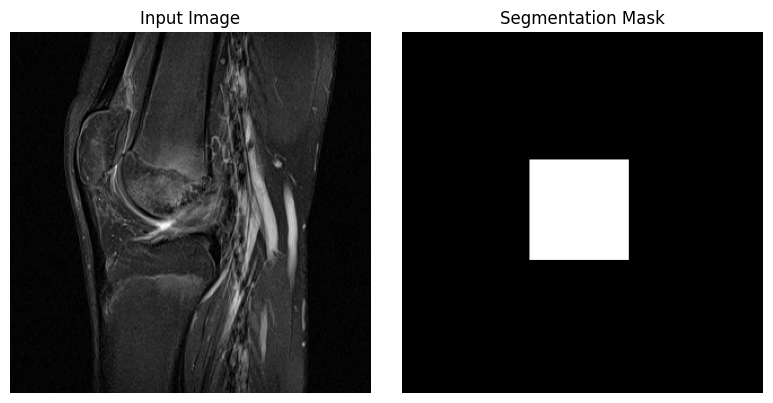

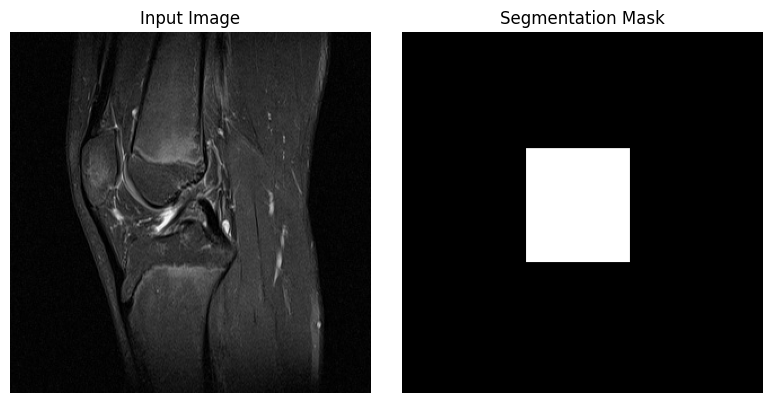

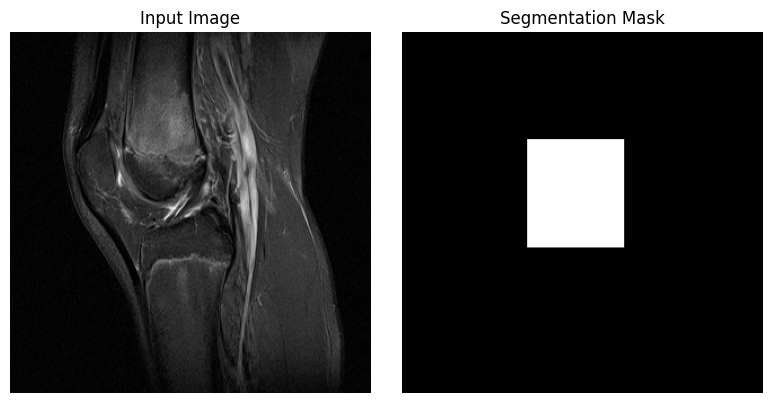

In [14]:
import matplotlib.pyplot as plt

# Show 3 random training samples
import random
n_samples = 3
indices = random.sample(range(len(X_train)), n_samples)

for idx in indices:
    image = X_train[idx, :, :, 0]  # shape: (320, 320)
    mask  = y_train[idx, :, :, 0]  # shape: (320, 320)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [15]:
#dimensions

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)


(320, 320, 1)


U NET MODEL

In [16]:
#convolution bloack: S1
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x


In [17]:
#encoder block: conv block (s1) followed by maxpooling
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D((2, 2))(x)
  return x, p

In [18]:
#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = concatenate([x, skip_features])
  x = conv_block(x, num_filters)
  return x


In [19]:
#build unet
def build_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
  model = Model(inputs, outputs, name="U-Net")
  return model

In [20]:
#build the model
model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 320, 320,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 320, 320,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 320, 320,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 320, 320,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 160, 160,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 160, 160,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 160, 160,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 80, 80,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 80,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [21]:
# from keras.preprocessing.image import ImageDataGenerator

# seed = 24           # keeps image + mask transforms in sync


# img_data_gen_args = dict(
#     rotation_range=90,        # random 0‑90° rotation
#     width_shift_range=0.3,    # ±30 % horizontal translation
#     height_shift_range=0.3,   # ±30 % vertical translation
#     shear_range=0.5,          # shear up to 0.5 rad
#     zoom_range=0.3,           # random zoom‑in/out
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='reflect'       # fill empty pixels by mirroring
# )


# mask_data_gen_args = dict(
#     rotation_range=90,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.5,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='reflect',
#     preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(np.uint8)

# )
# batch_size = 8


# image_data_generator = ImageDataGenerator(**img_data_gen_args)
# mask_data_generator  = ImageDataGenerator(**mask_data_gen_args)


# image_generator      = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
# valid_img_generator  = image_data_generator.flow(X_test,  seed=seed, batch_size=batch_size)


# mask_generator       = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
# valid_mask_generator = mask_data_generator.flow(y_test,  seed=seed, batch_size=batch_size)

# def my_image_mask_generator(image_generator, mask_generator):
#     for img_batch, mask_batch in zip(image_generator, mask_generator):
#         yield img_batch, mask_batch
# my_generator       = my_image_mask_generator(image_generator, mask_generator)
# validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)
# x = image_generator.next()      # shape (8, 320, 320, 1)
# y = mask_generator.next()       # shape (8, 320, 320, 1)

# for i in range(1):              # just the first image in the batch
#     plt.subplot(1,2,1); plt.imshow(x[i][:,:,0], cmap='gray')
#     plt.subplot(1,2,2); plt.imshow(y[i][:,:,0])   # mask – usually 0/1
#     plt.show()
# steps_per_epoch = 3 * (len(X_train)) // batch_size





In [ ]:


BATCH_SIZE = 8
EPOCHS     = 50

history = model.fit(
    X_train, y_train,
    batch_size      = BATCH_SIZE,
    epochs          = EPOCHS,
    shuffle         = True,
    validation_data = (X_test, y_test)
)


Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 279s 886ms/step - accuracy: 0.9656 - loss: 0.1153 - val_accuracy: 0.9231 - val_loss: 0.2130
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 186s 799ms/step - accuracy: 0.9837 - loss: 0.0407 - val_accuracy: 0.9471 - val_loss: 0.2373
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 201s 794ms/step - accuracy: 0.9848 - loss: 0.0366 - val_accuracy: 0.9791 - val_loss: 0.0599
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 202s 794ms/step - accuracy: 0.9858 - loss: 0.0333 - val_accuracy: 0.9811 - val_loss: 0.0516
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 202s 795ms/step - accuracy: 0.9862 - loss: 0.0324 - val_accuracy: 0.9668 - val_loss: 0.1030
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 203s 801ms/step - accuracy: 0.9866 - loss: 0.0312 - val_accuracy: 0.9852 - val_loss: 0.0361
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 202s 801ms/step - accuracy: 0.9872 - loss: 0.0298 - val_accuracy: 0.9847 - val_loss: 0.0364
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 185s 793ms/step - accuracy: 0.9870 -

In [ ]:
## CNN for classification